In [13]:
from moku.instruments import LaserLockBox
import matplotlib.pyplot as plt
import numpy as np

In [14]:
LLB = LaserLockBox('192.168.50.97', force_connect=True, platform_id=4) #192.168.50.97 Moku pro 1 ---- 192.168.50.63 Moku pro 4

In [15]:
LLB.set_frontend(1, "AC", "50Ohm", "0dB")
LLB.set_frontend(2, "DC", "50Ohm", "0dB")

{'attenuation': '0dB', 'coupling': 'DC', 'impedance': '50Ohm'}

In [17]:
LLB.set_output_limit(channel=1, low_limit=-1, high_limit=1)
LLB.set_output(1, signal=False, output=True)

{'gain_range': '0dB', 'output': True, 'signal': False}

In [18]:
LLB.set_monitor(1, 'LowpassFilter')
LLB.set_monitor(2, 'Input2')
LLB.set_acquisition_mode(mode="Precision")

{'mode': 'Precision'}

In [19]:
LLB.set_pid_by_frequency(channel=1,  int_crossover = 18e3, int_saturation = 40.0,prop_gain = 0)
print(LLB.summary())

Moku:Pro Laser Lock Box
Input 1, AC coupling, 50 Ohm impedance, 0 dB attenuation, 0 dB gain
Input 2, DC coupling, 50 Ohm impedance, 0 dB attenuation
Demodulating using modulation signal, phase shift 80.000 000 deg
Lowpass filter: 4th-order Butterworth Lowpass, corner frequency 1.000 MHz, sampling rate 78.125 MHz
Setpoint: 0.000 0 V
Fast controller: PI controller: proportional gain +0.0 dB, integrator crossover 18.00 kHz, integrator saturation +40.0 dB, invert off
Slow controller: PI controller: proportional gain -10.0 dB, integrator crossover 49.00 Hz, integrator saturation +40.0 dB, invert off
Scan - Positive ramp, 10.000 000 Hz, 500 mVpp, Output 1
Modulation - 50.800 000 000 000 MHz, 2.000 Vpp, Output 3, 0 dB gain
Output 1 - control signal disabled, offset 0.000 0 V, limits disabled, 0 dB output gain, output enabled
Output 2 - control signal disabled, offset 0.000 0 V, limits disabled, 0 dB output gain, output disabled
External 10 MHz clock


In [20]:
LLB.set_scan_oscillator(enable=True,amplitude = 1, frequency = 10, output ="Output1",shape =  "Triangle")

{'amplitude': 1.0,
 'enabled': True,
 'frequency': 10.0,
 'output': 'Output1',
 'shape': 'Triangle'}

In [21]:
LLB.set_trigger(type="Edge", source="Scan", level=0)

{'edge': 'Rising',
 'hf_reject': False,
 'holdoff': 0.0,
 'hysteresis': 0.001,
 'level': 0.0,
 'noise_reject': False,
 'nth_event': 1}

In [45]:
LLB.set_demodulation(mode="Modulation",frequency=50.8e6,phase=20)
LLB.set_aux_oscillator(enable = True,frequency=50.8e6,amplitude=2,output = "Output3")

{'amplitude': 2.0,
 'enabled': True,
 'frequency': 50800000.0,
 'source': 'Output3'}

In [46]:
LLB.set_timebase(0.0,0.1)
LLB.set_output_offset(1, offset=0.0)

dict_keys(['ch1', 'ch2', 'ch3', 'ch4', 'time'])

In [92]:
import time
import pickle as pkl

In [103]:
data = []
total = 240
count = 0
while count < total:
    data.append(LLB.get_data(wait_complete=True))
    count = count+1
    time.sleep(60)
    with open("test.pkl",'wb') as handle:
        pkl.dump(data,handle)

In [110]:
with open("pdhErrorData.pkl",'rb') as handle:
    alldata = pkl.load(handle)

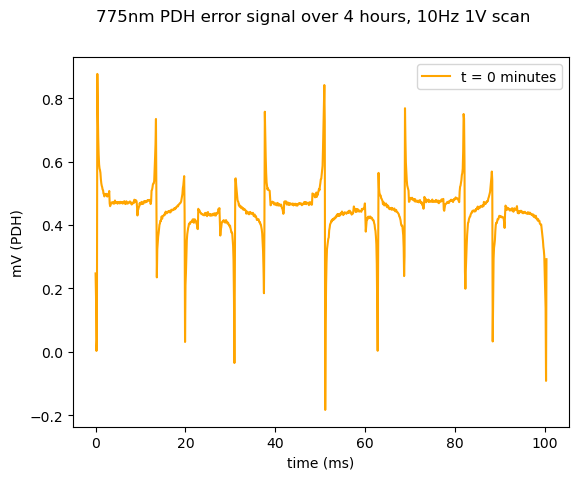

In [150]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('mV (PDH)')
#ax2 = ax1.twinx()
#ax2.set_ylabel('mV (trans)')
fig.suptitle("775nm PDH error signal over 4 hours, 10Hz 1V scan")

data = alldata[0]
t = np.array(data['time'])*1e3
err = np.array(data['ch1'])*1e3
trans = np.array(data['ch2'])*1e3

pdherr = ax1.plot(t,err, color = "orange")[0]
ax1.legend([f"t = 0 minutes"],loc = "upper right")
#transsig = ax2.plot(t,trans, color = "blue")[0]

def update(frame):
    data = alldata[frame]
    t = np.array(data['time'])*1e3
    err = np.array(data['ch1'])*1e3
    #trans = np.array(data['ch2'])*1e3
    pdherr.set_xdata(t)
    pdherr.set_ydata(err)
    #transsig.set_xdata(t)
    #transsig.set_ydata(trans)
    ax1.set_ylim([min(err),max(err)])
    ax1.legend([f"t = {frame} minutes"],loc = "upper right")
    if frame == 239:
        ax1.text(50,0,"RESET")


In [151]:
import matplotlib.animation as animation

ani = animation.FuncAnimation(fig=fig, func=update, frames=240, interval=300)
plt.show()

In [152]:
ani.save(filename="pdh4hrs.gif", writer="pillow")

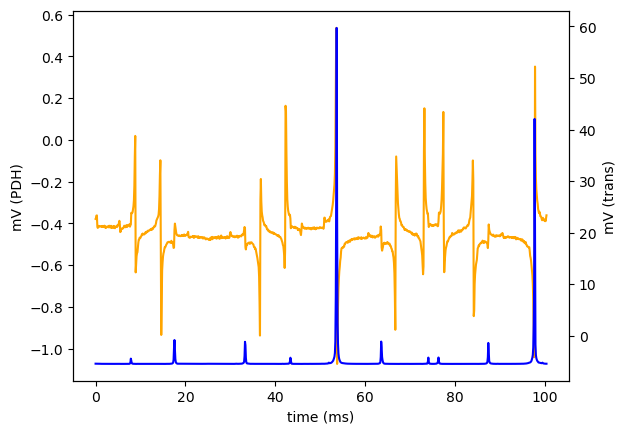

In [115]:
data = alldata[100]
t = np.array(data['time'])*1e3
err = np.array(data['ch1'])*1e3
trans = np.array(data['ch2'])*1e3

fig, ax1 = plt.subplots()
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('mV (PDH)')
pdherr = ax1.plot(t,err, color = "orange")


ax2 = ax1.twinx()
ax2.set_ylabel('mV (trans)')
transsig = ax2.plot(t,trans, color = "blue")


In [122]:
print(len(alldata))

240


In [154]:
from statistics import median

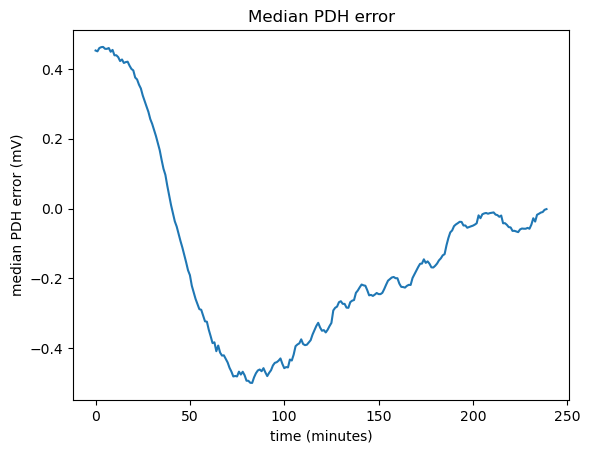

In [158]:
medianpdh = [median(data['ch1'])*1e3 for data in alldata]
plt.title("Median PDH error")
plt.xlabel("time (minutes)")
plt.ylabel("median PDH error (mV)")
plt.plot(medianpdh)

In [116]:
LLB.relinquish_ownership()